In [3]:
# Need the older version of pandas for pickling the xarray to work. 
# !pip install "pandas<2.0.0"
import pickle
import numpy as np
import pandas as pd
import os
import cv2
import json
import matplotlib.pyplot as plt
import xarray as xr
import tifffile
from PIL import Image
from dea_tools.plotting import display_map, rgb, xr_animation
from datetime import datetime

In [2]:
def create_lat_lon(bbox, shape):
    """ Create the latitudes and longitudes

    Parameters
    ----------
    bbox: list of float
    shape: list of int
    
    Returns
    -------
    x: 1d-array
    y: 1d-array
    """
    pixel_size = (bbox[2] - bbox[0])/shape[0], (bbox[3] - bbox[1])/shape[1]
    y = np.arange(bbox[0], bbox[2], pixel_size[0])
    x = np.arange(bbox[1], bbox[3], pixel_size[1])
    return x, y

In [3]:
def normalized(band):
    return band / np.sqrt(np.sum(band**2))

In [4]:
def merge_rgb_datasets(ds1, ds2, crs='EPSG:32755'):
    """ 
    Combines two rgb xarrays
    Assumes bands are named (nbart_red, nbart_green, nbart_blue), each with dimensions (time, y, x)
    Sorts by timestamp for compatibility with dea_tools.plotting.xr_animation

    Parameters
    ----------
    ds1: xarray.Dataset
    ds2: xarray.Dataset

    Returns
    ----------
    ds_merged: xarray.Dataset
    """
    ds1_red = normalized(ds1["nbart_red"])
    ds1_green = normalized(ds1["nbart_green"])
    ds1_blue = normalized(ds1["nbart_blue"])
    ds2_red = normalized(ds2["nbart_red"])
    ds2_green = normalized(ds2["nbart_green"])
    ds2_blue = normalized(ds2["nbart_blue"])
    
    ds1_bands = list(zip(ds1["time"], ds1_red, ds1_green, ds1_blue))
    ds2_bands = list(zip(ds2["time"], ds2_red, ds2_green, ds2_blue))
    ds_merged_bands = sorted(ds1_bands + ds2_bands)
    time_merged = [t[0].values for t in ds_merged_bands]
    red_merged = [t[1] for t in ds_merged_bands]
    green_merged = [t[2] for t in ds_merged_bands]
    blue_merged = [t[3] for t in ds_merged_bands]
    x = ds1.x.values
    y = ds1.y.values
    ds_merged = xr.Dataset(
        {
            "nbart_red":(["time",  "y", "x"], red_merged),
            "nbart_green":(["time",  "y", "x"], green_merged),
            "nbart_blue":(["time",  "y", "x"], blue_merged),
        },
        coords={
            "time": time_merged,
            "y": ("y", y),
            "x": ("x", x),
        },
    )
    ds_merged = ds_merged.odc.assign_crs(crs=crs)
    return ds_merged

In [1]:
filename_sentinel_2019 = 'sentinel_arbo_4bands_2019-2024.pickle'
filename_planetscope_2020 = 'planetscope_arbo_3bands_2020-2021.pickle'
filename_planetscope_2021 = 'planetscope_arbo_3bands_2021-2024.pickle'

In [4]:
with open(filename_sentinel_2019, 'rb') as handle:
    ds_sentinel_2019 = pickle.load(handle)
ds_sentinel_2019

<xarray.Dataset> Size: 999MB
Dimensions:      (time: 144, y: 660, x: 657)
Coordinates:
  * time         (time) datetime64[ns] 1kB 2019-01-15T00:06:27.817000 ... 202...
  * y            (y) float64 5kB 6.096e+06 6.096e+06 ... 6.09e+06 6.09e+06
  * x            (x) float64 5kB 6.857e+05 6.857e+05 ... 6.922e+05 6.922e+05
    spatial_ref  int32 4B 32755
Data variables:
    nbart_red    (time, y, x) float32 250MB 706.0 630.0 ... 1.29e+03 2.064e+03
    nbart_green  (time, y, x) float32 250MB 635.0 560.0 ... 1.115e+03 1.764e+03
    nbart_blue   (time, y, x) float32 250MB 416.0 380.0 ... 825.0 1.435e+03
    nbart_nir_1  (time, y, x) float32 250MB 2.197e+03 2.274e+03 ... 2.533e+03
Attributes:
    crs:           epsg:32755
    grid_mapping:  spatial_ref

In [7]:
with open(filename_planetscope_2020, 'rb') as handle:
    ds_planetscope_2020 = pickle.load(handle)
ds_planetscope_2020

<xarray.Dataset> Size: 1GB
Dimensions:      (time: 98, y: 660, x: 657)
Coordinates:
  * time         (time) datetime64[ns] 784B 2020-03-19T23:15:57 ... 2021-08-0...
  * y            (y) float64 5kB 6.856e+05 6.856e+05 ... 6.922e+05 6.922e+05
  * x            (x) float64 5kB 6.09e+06 6.09e+06 ... 6.096e+06 6.096e+06
    spatial_ref  int32 4B 32755
Data variables:
    nbart_red    (time, y, x) float64 340MB nan nan nan nan ... nan nan nan nan
    nbart_green  (time, y, x) float64 340MB nan nan nan nan ... nan nan nan nan
    nbart_blue   (time, y, x) float64 340MB nan nan nan nan ... nan nan nan nan

In [8]:
with open(filename_planetscope_2021, 'rb') as handle:
    ds_planetscope_2021 = pickle.load(handle)
ds_planetscope_2021

<xarray.Dataset> Size: 3GB
Dimensions:      (time: 312, y: 660, x: 657)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2021-08-11T23:15:40 ... 2024-02-27...
  * y            (y) float64 5kB 6.856e+05 6.856e+05 ... 6.922e+05 6.922e+05
  * x            (x) float64 5kB 6.09e+06 6.09e+06 ... 6.096e+06 6.096e+06
    spatial_ref  int32 4B 32755
Data variables:
    nbart_red    (time, y, x) float64 1GB nan nan nan nan ... nan nan nan nan
    nbart_green  (time, y, x) float64 1GB nan nan nan nan ... nan nan nan nan
    nbart_blue   (time, y, x) float64 1GB nan nan nan nan ... nan nan nan nan

In [9]:
ds1 = ds_planetscope_2020
ds2 = ds_planetscope_2021
ds3 = ds_sentinel_2019

In [10]:
ds2 = merge_rgb_datasets(ds1, ds2)

In [11]:
ds3 = merge_rgb_datasets(ds2, ds3)

In [12]:
ds3

<xarray.Dataset> Size: 6GB
Dimensions:      (time: 554, y: 660, x: 657)
Coordinates:
  * time         (time) datetime64[ns] 4kB 2019-01-15T00:06:27.817000 ... 202...
  * y            (y) float64 5kB 6.856e+05 6.856e+05 ... 6.922e+05 6.922e+05
  * x            (x) float64 5kB 6.09e+06 6.09e+06 ... 6.096e+06 6.096e+06
    spatial_ref  int32 4B 32755
Data variables:
    nbart_red    (time, y, x) float64 2GB 0.0001108 9.891e-05 ... 0.0003241
    nbart_green  (time, y, x) float64 2GB 0.0001118 9.855e-05 ... 0.0003104
    nbart_blue   (time, y, x) float64 2GB 0.0001017 9.294e-05 ... 0.000351

/Users/christopherbradley/miniconda3/envs/cubeenv/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


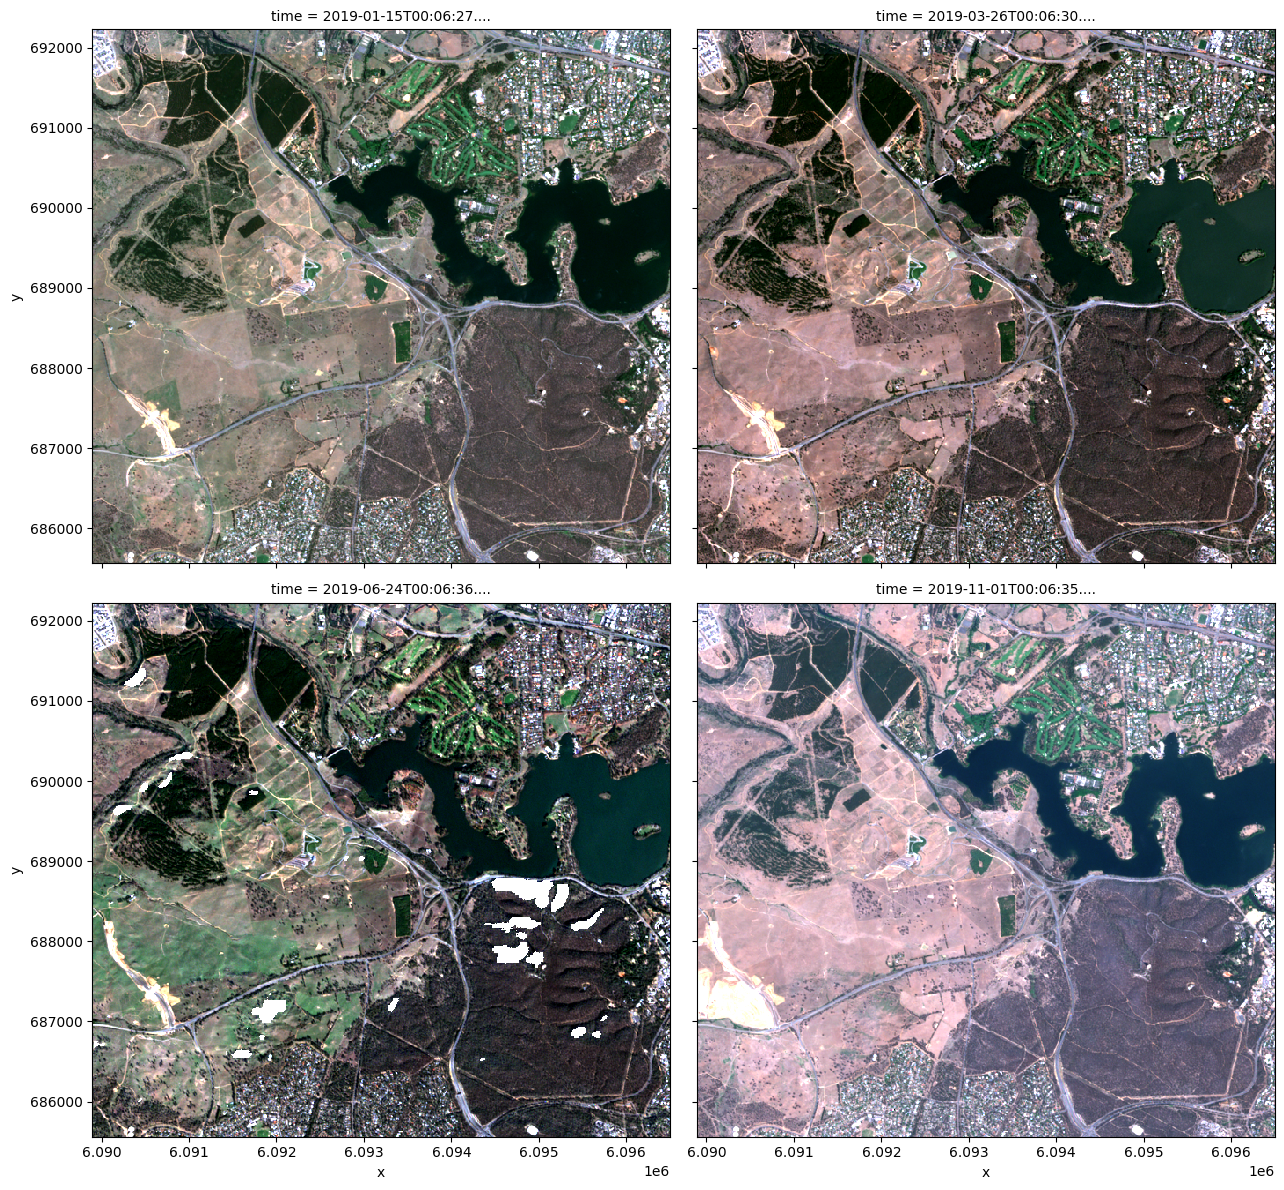

In [13]:
rgb(ds3, index=[0,10,20,30], col_wrap=2)

Exporting animation to animation.mp4


  0%|          | 0/554 (0.0 seconds remaining at ? frames/s)

/Users/christopherbradley/miniconda3/envs/cubeenv/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


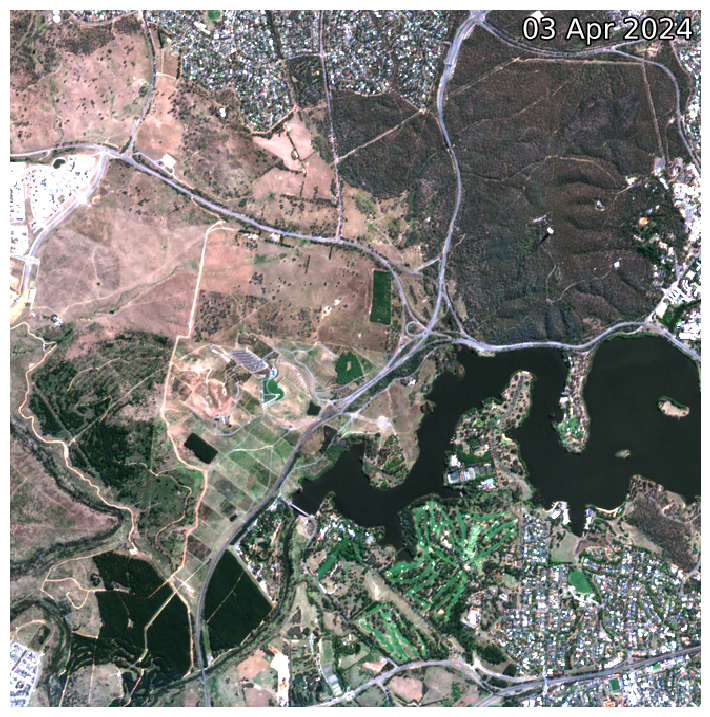

In [14]:
xr_animation(ds3, bands=['nbart_red', 'nbart_green', 'nbart_blue'])